In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
## check if GPU is available and use it otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#****************** Problem 1.a. ***********************#
#* Hint: make use ot torch.autograd.grad to find df_dx *# 

x = torch.tensor([0.1, 1., 2.], requires_grad=True)

#****************** 1.a Write here   *******************#

f = 3 * torch.pow(x, 5) + torch.log(x) + x
df_dx = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f))

#****************** End write here *********************#

#****************** Print gradients ********************#

print('Your solution = ', df_dx)
print('True solution = ', 15 * x**4 + 1/x + 1)


Your solution =  (tensor([ 11.0015,  17.0000, 241.5000]),)
True solution =  tensor([ 11.0015,  17.0000, 241.5000], grad_fn=<AddBackward0>)


In [ ]:
###### Problem 1: Solving a ODE with a PINN network


# This is a simple case of an NN with a single hidden layer of 50 neurons. The MSE of the 
# ODE residual is used as a softconstraint via the loss function.

net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1, bias=False))

#****************** 1.b.1 Start Here   *******************#

# Initial condition
u_0 = 0.5

#****************** 1.b.1 End Here   *******************#

#****************** 1.b.2 Start Here   *******************#

def ut(t):
    return u_0 + t * net(t)

#****************** 1.b.2 End Here   *******************#

#* Check if you answer satisfies some main point *******#
#* This does not imply that the answer is correct *******#

print('Your solution for [u(0), u(.5)] = ', ut(torch.tensor([0 , .5])[:, None])[:,0].detach().numpy())
print('Expected solution for [u(0), u(.5)] = [1/2, Not .5]')

Your solution for [u(0), u(.5)] =  [0.5        0.20465639]
Expected solution for [u(0), u(.5)] = [1/2, Not .5]


In [ ]:
#****************** 1.b.3 Start Here   *******************#

def f(t,u):
    return u * torch.cos(t)

#******************  1.b.3 End Here   ********************#

#* Check if you answer passes some tests ****************#
#* This does not imply that the answer is correct *******#

print('Your solution [f(-.5), f(.5)] = ', f(torch.tensor([-.5 , .5])[:, None], ut(torch.tensor([-.5 , .5])[:, None]))[:,0].detach().numpy())
print('True solution [f(-.5), f(.5)] = [-0.2533674  -0.38583198]')

Your solution [f(-.5), f(.5)] =  [0.5830161  0.17960288]
True solution [f(-.5), f(.5)] = [-0.2533674  -0.38583198]


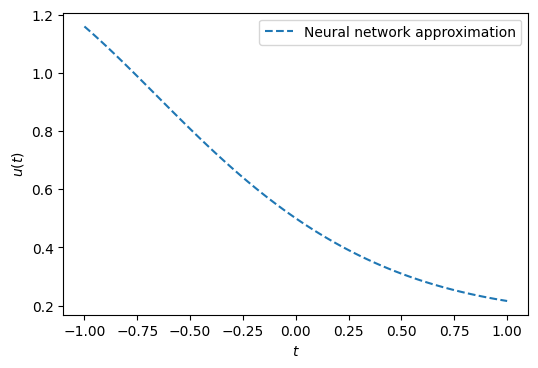

In [ ]:
def loss(t):
    
    t.requires_grad = True
    ut_outputs = ut(t)
    dut_dt = torch.autograd.grad(ut_outputs, t, grad_outputs=torch.ones_like(ut_outputs),
                                  create_graph=True)[0]
    
    #****************** 1.b.4 Start Here   *******************#
    
    pred = dut_dt + f(t, ut_outputs)
    output_loss = ((pred - torch.zeros_like(pred))**2).mean()
    return  output_loss
    
    #****************** 1.b.4 End Here   ********************#

optimizer = torch.optim.LBFGS(net.parameters())

#collocation points
t = torch.Tensor(np.linspace(-1, 1, 100)[:, None])

#closure function to run optimizer in
def closure():

    optimizer.zero_grad()
    l = loss(t)
    l.backward()
    
    return l

for i in range(10):
    optimizer.step(closure)
    
tt = np.linspace(-1, 1, 100)[:, None]
with torch.no_grad():
    u_approx = ut(torch.Tensor(tt)).numpy()
fig, ax = plt.subplots(dpi=100)
ax.plot(tt, u_approx, '--', label='Neural network approximation')
ax.set_xlabel('$t$')
ax.set_ylabel('$u(t)$')
plt.legend(loc='best');

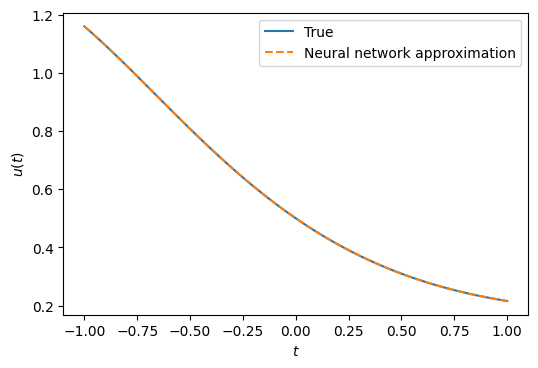

In [ ]:
# Comparison with analytic solution. 

tt = np.linspace(-1, 1, 100)[:, None]

with torch.no_grad():
    u_approx = ut(torch.Tensor(tt)).numpy()
    
#****************** 1.d Start Here   *******************#

ut_true = 0.5 * torch.exp(-torch.sin(torch.Tensor(tt)))

#****************** 1.d End Here   ********************#

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, ut_true, label='True')
ax.plot(tt, u_approx, '--', label='Neural network approximation')
ax.set_xlabel('$t$')
ax.set_ylabel('$u(t)$')
plt.legend(loc='best');